 **Code** 

## Libraries required

In [55]:
from google.colab import drive
drive.mount('drive')
# Importing packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
import pandas as pd
device =  'cpu' # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Functions used

### Input prepartion functions

Convert trajectory tensor to our required format

In [56]:
def trajectory_conversion(trajectory):
  input_trajectory = torch.zeros(len(trajectory), 3)
  for i in range(1, trajectory.size()[0]):
    del_x = trajectory[i][0]-trajectory[i-1][0]
    del_y = trajectory[i][1]-trajectory[i-1][1]
    del_z = trajectory[i][2]-trajectory[i-1][2]

    input_trajectory[i][0] = del_x

    input_trajectory[i][1] = del_y

    input_trajectory[i][2] = del_z

  return input_trajectory

In [57]:
def create_inout_sequences(input_data, tw=100):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw].to(device)
        train_label = input_data[i+tw].to(device) #changed to correct error
        inout_seq.append((train_seq ,train_label))
    return inout_seq

### model

In [58]:
class LSTM(nn.Module):
    def __init__(self, input_size=3, hidden_layer_size=128, output_size=3):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size, device=device),
                            torch.zeros(1,1,self.hidden_layer_size, device=device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        lstm_out = F.relu(lstm_out.view(len(input_seq), -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

### training

In [59]:
def train_model(net, train_inout_seq, lr=0.001, epochs=20, device=device):
  model = net.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss_function = nn.MSELoss()
  model.train()
  #print(model)
  for i in range(epochs):
    #optimizer.zero_grad()
    for seq, labels in train_inout_seq:
      optimizer.zero_grad()
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size, device=device), torch.zeros(1, 1, model.hidden_layer_size, device=device))

      pred = model(seq)

      single_loss = loss_function(pred, labels)
      single_loss.backward()
      optimizer.step()
    #optimizer.step()
    #if i%25 == 1:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

  #print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
  return model

### testing/predicting

In [60]:
def getTrain_TestTensor(filename):
  data = pd.read_csv(filename)
  df = pd.DataFrame(data)
  df = df.drop(columns=['#date', 'ssh[m]', 'average_ssh[m]', 'geoid_height[m]', 'tide_height[cm]'])
  df['timestamp'] = pd.to_timedelta(df['time']).astype('timedelta64[s]').astype(int)
  df['relative_timestamp'] = df['timestamp']-df['timestamp'][0]
  df = df.drop(columns=['time', 'timestamp'])
  tl = int(len(df)*0.68)
  print(tl)
  testSize = int(len(df)) - tl
  print(testSize)

  trainTensor = torch.zeros(tl, 3).to(device)
  trainTensor[0][0] = df['latitude'][0]
  trainTensor[0][1] = df['longitude'][0]
  trainTensor[0][2] = df['flight_altitude[m]'][0]
  print(trainTensor.shape)
  #Remove unneccary points
  j = 0
  for i in range(1, tl):
    if(df['relative_timestamp'][i]!=df['relative_timestamp'][i-1]):
      j+=1
      trainTensor[j][0] = df['latitude'][i]
      trainTensor[j][1] = df['longitude'][i]
      trainTensor[j][2] = df['flight_altitude[m]'][i]
  trainTensor = trainTensor[trainTensor.abs().sum(dim=1) != 0]
  testTensor = torch.zeros(testSize, 3).to(device)
  testTensor[0][0] = df['latitude'][tl]
  testTensor[0][1] = df['longitude'][tl]
  testTensor[0][2] = df['flight_altitude[m]'][tl]
  j = 0
  for i in range(tl, len(df)):
    if(df['relative_timestamp'][i]!=df['relative_timestamp'][i-1]):
      j+=1
      testTensor[j][0] = df['latitude'][i]
      testTensor[j][1] = df['longitude'][i]
      testTensor[j][2] = df['flight_altitude[m]'][i]
  testTensor = testTensor[testTensor.abs().sum(dim=1) != 0]
  print(len(trainTensor), end = ' ')
  print(len(testTensor))
  return [trainTensor, testTensor]

In [61]:
#  dataz = pd.read_csv('flight20161208-7.csv')
#  dfz = pd.DataFrame(dataz)

In [62]:
# #  dfz = dfz.rename(columns={'lonitude':'longitude'})

In [63]:
#  dfz.to_csv('flight20161208-7.csv') #same as filee 7 but corrected column

## Main

In [64]:
# # Train the first file
# file1 = 'flight20161208-1.csv'
# trainTensor, testTensor = getTrain_TestTensor(file1)
# train_window = 50
# testSize = len(testTensor)
# conv_tT = trajectory_conversion(trainTensor)
# train_inout_seq = create_inout_sequences(conv_tT, train_window)
# net = LSTM()
# tm = train_model(net, train_inout_seq, epochs=15) #training code
# torch.save(tm.state_dict(), 'trained_model.pth')

### Train Model

In [65]:

# restOfFiles = ['flight20161208-2.csv', 'flight20161208-3.csv', 'flight20161208-4.csv', 'flight20161208-7.csv']
# for f in restOfFiles:
#   trainingTensor, testingTensor = getTrain_TestTensor(f)
#   train_window = 50
#   conv_tT = trajectory_conversion(trainTensor)
#   train_inout_seq = create_inout_sequences(conv_tT, train_window)
#   net = LSTM()
#   net.load_state_dict(torch.load('trained_model.pth'))
#   tm = train_model(net, train_inout_seq, epochs=15) #training code
#   torch.save(tm.state_dict(), 'trained_model.pth')  

In [66]:
# full = torch.cat((trainTensor, testTensor), axis = 0)
# fullCPU = full.cpu()
# #testTensor = testTensor[30:]
# print(len(trainTensor))
# print(len(testTensor))

In [67]:
def predict_30(model, conv_tT, trainTensor, fut_pred=30, device=device):
  test_inputs = conv_tT[-train_window:]
  model.eval()
  for i in range(fut_pred):
    seq = test_inputs[-train_window:].to(device)
    with torch.no_grad():
      model.hidden = (torch.zeros(1, 1, model.hidden_layer_size, device=device), torch.zeros(1, 1, model.hidden_layer_size, device=device))
      Pred = model(seq)
      newObservation = torch.tensor([[Pred[0], Pred[1], Pred[2]]])      
      torch.cat((test_inputs, newObservation))
  X = []
  Y = []
  Z = []
  trainTensor[-1][0].item()
  trainTensor[-1][1].item()
  for x, y, z in test_inputs[-fut_pred:]:
    X.append(x)
    Y.append(y)
    Z.append(z)
    #print(x, y, z)
  X = np.asarray(X)
  Y = np.asarray(Y)
  Z = np.asarray(Z)
  X = np.cumsum(X)
  Y = np.cumsum(Y)
  Z = np.cumsum(Z)
  X_f = X+trainTensor[-1][0].item()
  Y_f = Y+trainTensor[-1][1].item()
  Z_f = Z+trainTensor[-1][2].item()
  #plt.plot(X_f, Y_f)
  #plt.show()
  #print(X_f)
  #print(Y_f)
  predicted = torch.zeros(fut_pred, 3).to(device)
  for i in range(fut_pred):
    predicted[i][0] = X_f[i].item()
    predicted[i][1] = Y_f[i].item()
    predicted[i][2] = Z_f[i].item()
  return [predicted, X_f, Y_f, Z_f]

In [68]:
def Completed_trajectory(model, conv_tT, trainTensor, fut_pred, testTensor, plot=True, device=device, merge=False):
  X_f = np.asarray([])
  Y_f = np.asarray([])
  Z_f = np.asarray([])
  predicted_tensor = torch.zeros(1, 3).to(device)
  predicted_tensor[0] = trainTensor[-1]
  temp = trainTensor[:]
  for i in range(int(fut_pred/30)):
    pred = predict_30(model, conv_tT, temp, 30, device)
    temp = torch.cat((temp, pred[0]))
    predicted_tensor = torch.cat((predicted_tensor, pred[0]))
    X_f = np.concatenate((X_f, pred[1]), axis=0)
    Y_f = np.concatenate((Y_f, pred[2]), axis=0)
    Z_f = np.concatenate((Z_f, pred[3]), axis=0)
  if fut_pred%30!=0:
    pred = predict_30(model, conv_tT, temp, int(fut_pred%30), device)
    temp = torch.cat((temp, pred[0]))
    predicted_tensor = torch.cat((predicted_tensor, pred[0]))
    X_f = np.concatenate((X_f, pred[1]), axis=0)
    Y_f = np.concatenate((Y_f, pred[2]), axis=0)
    Z_f = np.concatenate((Z_f, pred[3]), axis=0)

  if plot:
    plt.plot(trainTensor[:, :1].cpu(), trainTensor[:, 2:].cpu(), label='train')
    plt.plot(testTensor[:, :1].cpu(), testTensor[:, 2:].cpu(), label='test')
    plt.xlabel('latitude')
    plt.ylabel('altitude')
    plt.legend()
    plt.show()

    plt.plot(trainTensor[:, :1].cpu(), trainTensor[:, 2:].cpu(), label='train')
    plt.plot(X_f, Z_f, label='predicted')
    plt.xlabel('latitude')
    plt.ylabel('altitude')
    plt.legend()
    plt.show()

    plt.plot(trainTensor[:, :1].cpu(), trainTensor[:, 2:].cpu(), label='train')
    plt.plot(testTensor[:, :1].cpu(), testTensor[:, 2:].cpu(), label='test')
    plt.plot(X_f, Z_f, label='predicted')
    plt.xlabel('latitude')
    plt.ylabel('altitude')
    plt.legend()
    plt.show()
  if(merge):
    return temp
  return predicted_tensor[1:]

In [69]:
# prediction = Completed_trajectory(tm, conv_tT, trainTensor, 50, testTensor, device=device)

In [70]:
# print(len(prediction))
# print(len(testTensor))

In [71]:
# testPlot = testTensor.cpu()
# print(testSize - len(prediction))
# testPlot = testPlot[-(len(testTensor) - len(prediction)):]
# plt.plot(trainTensor[:, :1].cpu(), trainTensor[:, 2:].cpu(), label='train')
# plt.plot(prediction[:, :1].cpu(), prediction[:, 2:].cpu(), label='predicted')
# plt.plot(testPlot[:, :1].cpu(), testPlot[:, 2:], label='test')
# plt.legend()
# plt.show()


### Predict the next n points given the current point.
Useful when there is loss of radio contact with the air object.

In [90]:
def getNextNPoints(model, conv_tT, n, step, totalLen, completeTensor):
  X_f = np.asarray([])
  Y_f = np.asarray([])
  Z_f = np.asarray([])
  predicted_tensor = torch.zeros(1, 3).to(device)
  predicted_tensor[0] = completeTensor[-1]
  temp = completeTensor[:step]
  firstPart = completeTensor[:step]
  remainingSize = totalLen - step - n
  thirdPart = completeTensor[-(remainingSize):]
  print(len(completeTensor))
  print(len(firstPart), end = ' ')
  print(len(thirdPart))
  for i in range(int(n/30)):
    pred = predict_30(model, conv_tT, temp, 30, device)
    temp = torch.cat((temp, pred[0]))
    predicted_tensor = torch.cat((predicted_tensor, pred[0]))
    X_f = np.concatenate((X_f, pred[1]), axis=0)
    Y_f = np.concatenate((Y_f, pred[2]), axis=0)
    Z_f = np.concatenate((Z_f, pred[3]), axis=0)
  if n%30!=0:
    pred = predict_30(model, conv_tT, temp, int(n%30), device)
    temp = torch.cat((temp, pred[0]))
    predicted_tensor = torch.cat((predicted_tensor, pred[0]))
    X_f = np.concatenate((X_f, pred[1]), axis=0)
    Y_f = np.concatenate((Y_f, pred[2]), axis=0)
    Z_f = np.concatenate((Z_f, pred[3]), axis=0)

  secondPart = predicted_tensor[1:]
  listOfTraj = [firstPart, secondPart, thirdPart]
  first = pd.DataFrame((firstPart.cpu()).numpy())
  second = pd.DataFrame((secondPart.cpu()).numpy())
  third = pd.DataFrame((thirdPart.cpu()).numpy())
  # complete = pd.concat([train, test], axis=0)
  file1 = 'first' + typeName + '.csv'
  file2 = 'second' + typeName + '.csv'
  file3 = 'third' + typeName + '.csv'
  first.to_csv(file1)
  !cp file1.csv "drive/My Drive/"

  second.to_csv(file2)
  !cp file2.csv "drive/My Drive/"

  third.to_csv(file3)
  !cp file3.csv "drive/My Drive/"
  plotter(listOfTraj)

### Plotter function

In [73]:
def plotter(listOfTraj):
  names = ['train', 'prediction', 'Remaining', 'full']
  ind = 0
  for traj in listOfTraj:
    plt.plot(traj[:, :1].cpu(), traj[:, 2:].cpu(), label = names[ind])
    ind += 1
    plt.xlabel('latitude')
    plt.ylabel('altitude')
    plt.legend()
    
  plt.show()

In [74]:
def getCompleteTensor(filename):
  rm = 52
  data = pd.read_csv(filename)
  df = pd.DataFrame(data)
  z = (df['alt']*1e5).rolling(rm+1).mean()
  tl = int((len(df)-rm)*0.68)
  print(tl)
  testSize = int(len(df)-rm) - tl
  print(testSize)

  trainTensor = torch.zeros(tl, 3).to(device)
  trainTensor[0][0] = df['lat'][rm]
  trainTensor[0][1] = df['lon'][rm]
  trainTensor[0][2] = z[rm]*1e5
  print(trainTensor.shape)
  #Remove unneccary points

  for i in range(1, tl):
    trainTensor[i][0] = df['lat'][rm+i]
    trainTensor[i][1] = df['lon'][rm+i]
    trainTensor[i][2] = z[rm+i]*1e5
  #trainTensor = trainTensor[trainTensor.abs().sum(dim=1) != 0]
  testTensor = torch.zeros(testSize, 3).to(device)
  testTensor[0][0] = df['lat'][rm+tl]
  testTensor[0][1] = df['lon'][rm+tl]
  testTensor[0][2] = z[rm+tl]*1e5
  j = 0
  for i in range(tl, len(df)-rm):
    testTensor[j][0] = df['lat'][rm+i]
    testTensor[j][1] = df['lon'][rm+i]
    testTensor[j][2] = z[rm+i]*1e5
    j+=1
  #testTensor = testTensor[testTensor.abs().sum(dim=1) != 0]
  #print(len(trainTensor), end = ' ')
  #print(len(testTensor))
  completeTensor = torch.cat([trainTensor, testTensor], dim = 0)
  return completeTensor

In [75]:
#Upload files as csv to google drive.

def writeToCSV(file1, file2, file3):
  first = pd.DataFrame((file1.cpu()).numpy())
  second = pd.DataFrame((file2.cpu()).numpy())
  third = pd.DataFrame((file3.cpu()).numpy())
  # complete = pd.concat([train, test], axis=0)
  first.to_csv('firstFlight.csv')
  !cp first.csv "drive/My Drive/"
  second.to_csv('secondFlight.csv')
  !cp second.csv "drive/My Drive/"
  third.to_csv('thirdFlight.csv')
  !cp third.csv "drive/My Drive/"

In [76]:
# getNextNPoints(tm, conv_tT, 40, 550, len(full), full)

# LSTM Clusters

In [106]:
flightModel = LSTM()
flightModel.load_state_dict(torch.load('planeModel.pth'))

helicopterModel = LSTM()
helicopterModel.load_state_dict(torch.load('helicopterModel.pth'))

missileModel = LSTM()
missileModel.load_state_dict(torch.load('missileModel.pth'))

fighterJetModel = LSTM()
fighterJetModel.load_state_dict(torch.load('figherJetModel.pth'))

<All keys matched successfully>

In [78]:
train_window = 50

353
167
torch.Size([353, 3])
520
300 190


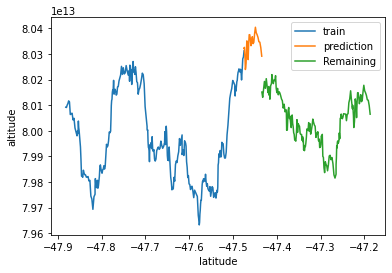

In [86]:
completeTensor = getCompleteTensor('flight_test.csv')
conv_T = trajectory_conversion(completeTensor)
typeName = 'Flight'
getNextNPoints(flightModel, conv_T.cpu(), 30, 300, len(completeTensor), completeTensor.cpu())

323
153
torch.Size([323, 3])
476
300 146
cp: cannot stat 'file1.csv': No such file or directory
cp: cannot stat 'file2.csv': No such file or directory
cp: cannot stat 'file3.csv': No such file or directory


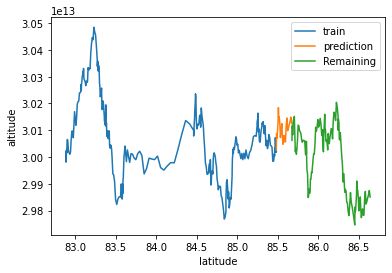

In [111]:
completeTensor = getCompleteTensor('helicopter_test.csv')
conv_T = trajectory_conversion(completeTensor)
typeName = 'Helicopter'
getNextNPoints(helicopterModel, conv_T.cpu(), 30, 300, len(completeTensor), completeTensor.cpu())

393
185
torch.Size([393, 3])
578
300 248
cp: cannot stat 'file1.csv': No such file or directory
cp: cannot stat 'file2.csv': No such file or directory
cp: cannot stat 'file3.csv': No such file or directory


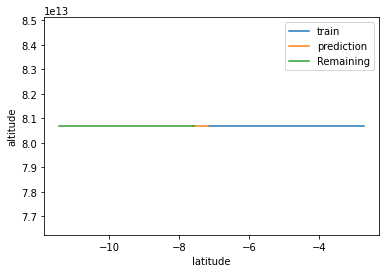

In [100]:
completeTensor = getCompleteTensor('missile_test.csv')
conv_T = trajectory_conversion(completeTensor)
typeName = 'Missile'
getNextNPoints(missileModel, conv_T.cpu(), 30, 300, len(completeTensor), completeTensor.cpu())

438
207
torch.Size([438, 3])
645
300 315
cp: cannot stat 'file1.csv': No such file or directory
cp: cannot stat 'file2.csv': No such file or directory
cp: cannot stat 'file3.csv': No such file or directory


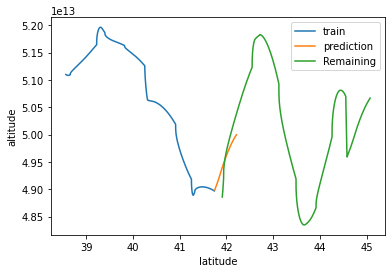

In [110]:
completeTensor = getCompleteTensor('fighter_jet_test.csv')
conv_T = trajectory_conversion(completeTensor)
typeName = 'Fighter_Jet'
getNextNPoints(fighterJetModel, conv_T.cpu(), 30, 300, len(completeTensor), completeTensor.cpu())